In [1]:
import sys

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2


In [3]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
import os
import pandas as pd
os.getcwd()

'/Volumes/groups/tanaka/People/current/jiwang/projects/heart_regeneration/scripts'

In [5]:
data_version = 'CMsutypesAll_2.1'

In [6]:
input_Dir = "../results/sc_multiome_R13591_intron.exon.20220729/RNA_velocity_kallisto/"
data_seuratObj = os.path.join(input_Dir, 
                              "RNAmatrix_umap_kalisto.velocity_spliced_unspliced_" + str(data_version) + ".h5ad")


In [22]:
outDir = "../results/sc_multiome_R13591_intron.exon.20220729/CM_trajectory_test/" + str(data_version)
if not os.path.exists(outDir):
   os.makedirs(outDir)

In [23]:
sc.settings.figdir = outDir + '/'
scv.settings.figdir = outDir + '/'

In [7]:
parameters = '_topGenes.3000_n.pcs.10_n.neighbors.30'

In [8]:
adata = sc.read_h5ad(data_seuratObj, chunk_size=6000)

In [9]:
adata

AnnData object with n_obs × n_vars = 6373 × 12446
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'iscell_dd', 'iscell_ed', 'condition', 'percent.mt', 'RNA_snn_res.0.7', 'seurat_clusters', 'RNA_snn_res.0.5', 'pANN_0.25_0.02_773', 'DF.classifications_0.25_0.02_773', 'pANN_0.25_0.01_606', 'DF.classifications_0.25_0.01_606', 'pANN_0.25_0.005_511', 'DF.classifications_0.25_0.005_511', 'pANN_0.25_0.005_610', 'DF.classifications_0.25_0.005_610', 'pANN_0.25_0.005_543', 'DF.classifications_0.25_0.005_543', 'subtypes', 'time', 'cell.ids', 'celltypes', 'cell.id', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'spliced_features', 'unspliced_features'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [10]:
outDir

'../results/sc_multiome_R13591_intron.exon.20220729/RNA_velocity_kallisto/CMsutypesAll_2.1'

In [11]:
adata.layers.keys()

KeysView(Layers with keys: spliced, unspliced)

In [12]:
adata.obs['condition']= adata.obs['condition'].astype('category') # change the condition into category type
adata.obs['celltypes']= adata.obs['celltypes'].astype('category')
adata.obs['cluster']= adata.obs['seurat_clusters'].astype('category')

In [13]:
adata.obs['condition'];

In [14]:
adata.obs['celltypes'];

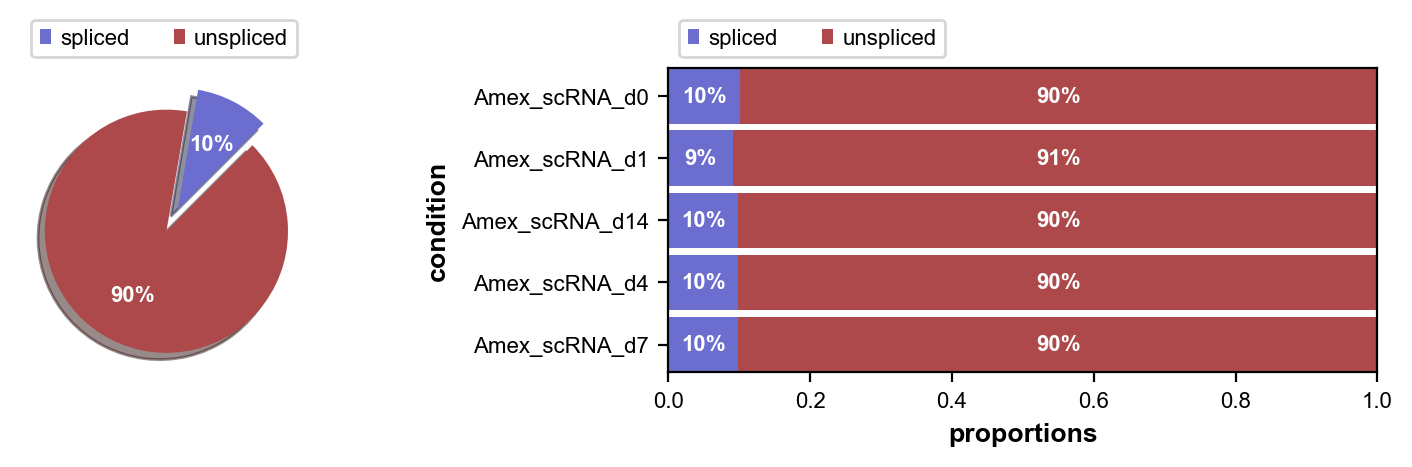

In [15]:
#adata = cr.datasets.pancreas()
scv.pl.proportions(adata, groupby='condition')


In [16]:
scv.pp.filter_and_normalize(adata, 
                            min_shared_counts=20, n_top_genes=3000, 
                            flavor = 'seurat', 
                            layers_normalize={'X', 'spliced', 'unspliced'}) # by specifying layers_normalize to renormalize the counts 
#sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=10)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)


Filtered out 4348 genes that are detected 20 counts (shared).
Normalized count data: X, unspliced, spliced.
Extracted 3000 highly variable genes.
         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
adata

AnnData object with n_obs × n_vars = 6373 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'iscell_dd', 'iscell_ed', 'condition', 'percent.mt', 'RNA_snn_res.0.7', 'seurat_clusters', 'RNA_snn_res.0.5', 'pANN_0.25_0.02_773', 'DF.classifications_0.25_0.02_773', 'pANN_0.25_0.01_606', 'DF.classifications_0.25_0.01_606', 'pANN_0.25_0.005_511', 'DF.classifications_0.25_0.005_511', 'pANN_0.25_0.005_610', 'DF.classifications_0.25_0.005_610', 'pANN_0.25_0.005_543', 'DF.classifications_0.25_0.005_543', 'subtypes', 'time', 'cell.ids', 'celltypes', 'cell.id', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'spliced_features', 'unspliced_features', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_umap

In [18]:
scv.tl.recover_dynamics(adata, n_jobs=10, max_iter=10) 

recovering dynamics (using 10/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [19]:
scv.tl.velocity(adata, mode="dynamical", 
                min_r2=0.01,
                min_likelihood=0.001)

scv.tl.velocity_graph(adata, approx = None, sqrt_transform = None)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [20]:
print(adata.var.velocity_genes.sum()) # check the genes used for RNA velocity

148


In [21]:
adata.var['velocity_genes']

RAMP2-AMEX60DD010004     False
CAVIN1-AMEX60DD010031    False
STAT5B-AMEX60DD010039    False
GHDC-AMEX60DD010041      False
PLCL2-AMEX60DD010043     False
                         ...  
ABCC8-AMEX60DD004697     False
NOX4-AMEX60DD049619      False
PCDH15-AMEX60DD052506    False
TRIM50-AMEX60DD054231    False
AMEX60DD054912           False
Name: velocity_genes, Length: 3000, dtype: bool

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ../results/sc_multiome_R13591_intron.exon.20220729/CM_trajectory_test/CMsutypesAll_2.1/RNAvelocity_stream_model_dynamical_topGenes.3000_n.pcs.10_n.neighbors.30.png


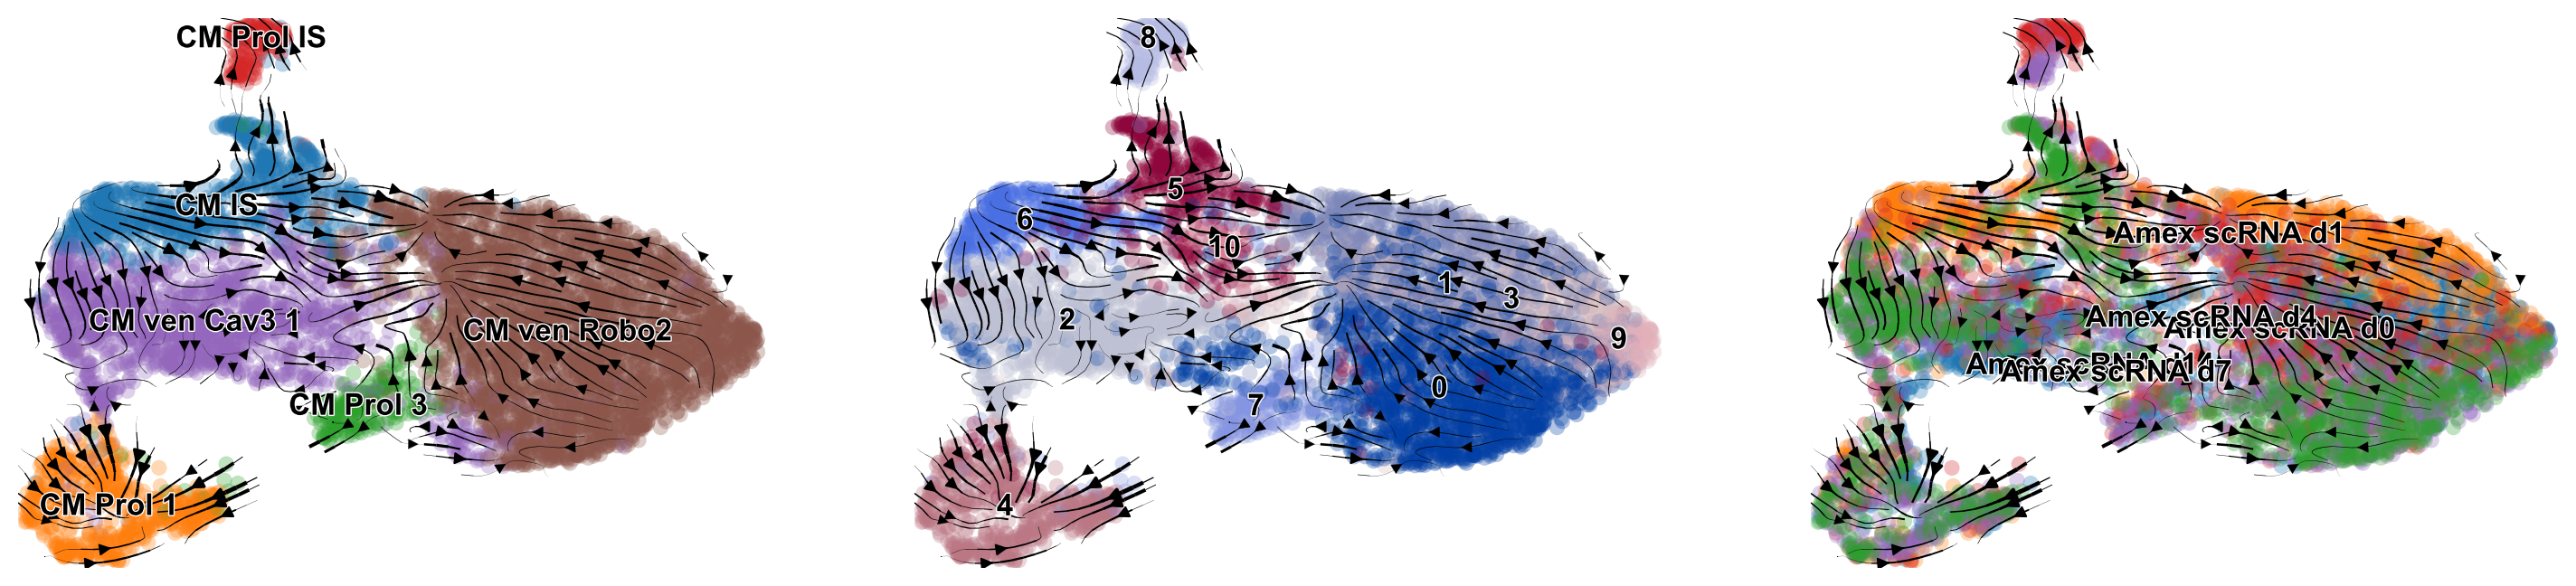

In [24]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", smooth=0.5, min_mass=1,
    legend_fontsize=12, title="", color = ['celltypes',  'cluster', 'condition'], 
    save=os.path.join(outDir, "RNAvelocity_stream_model_dynamical" + parameters + ".pdf"))

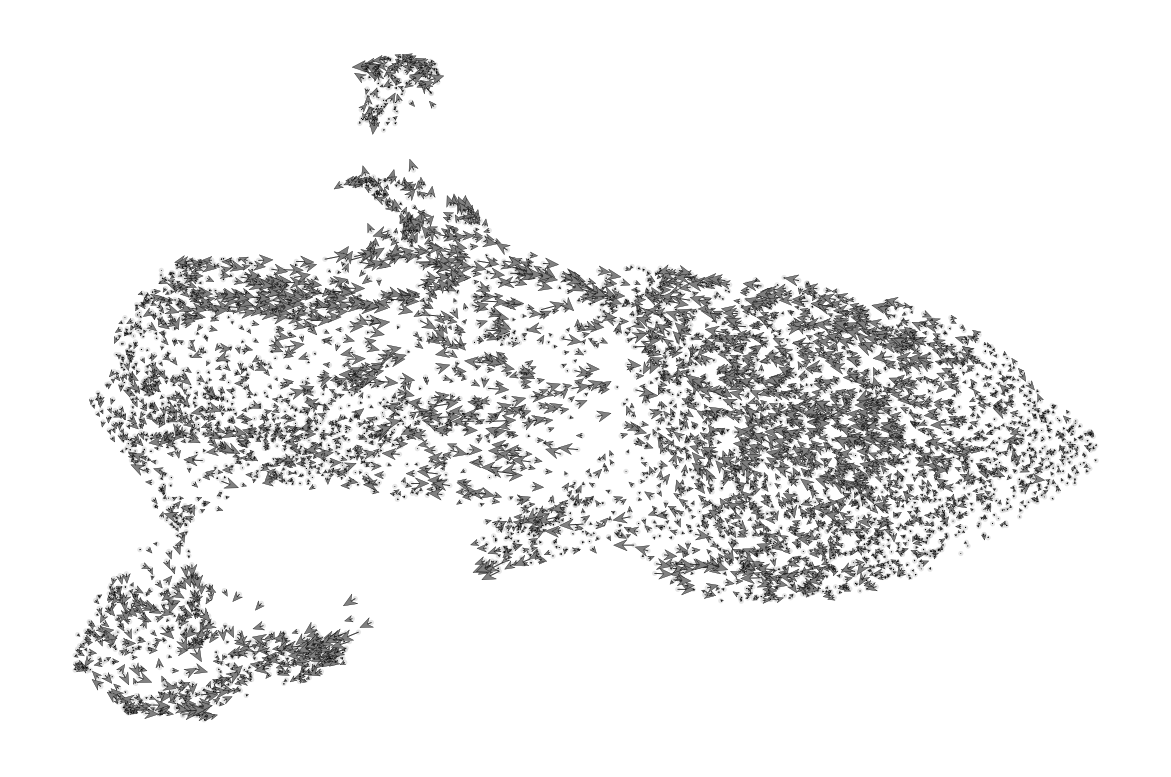

In [25]:
scv.pl.velocity_embedding(adata, dpi=120, arrow_size=2, arrow_length=4)


saving figure to file ../results/sc_multiome_R13591_intron.exon.20220729/CM_trajectory_test/CMsutypesAll_2.1/RNAvelocity_gridEmbedding_model_dynamical_topGenes.3000_n.pcs.10_n.neighbors.30.pdf


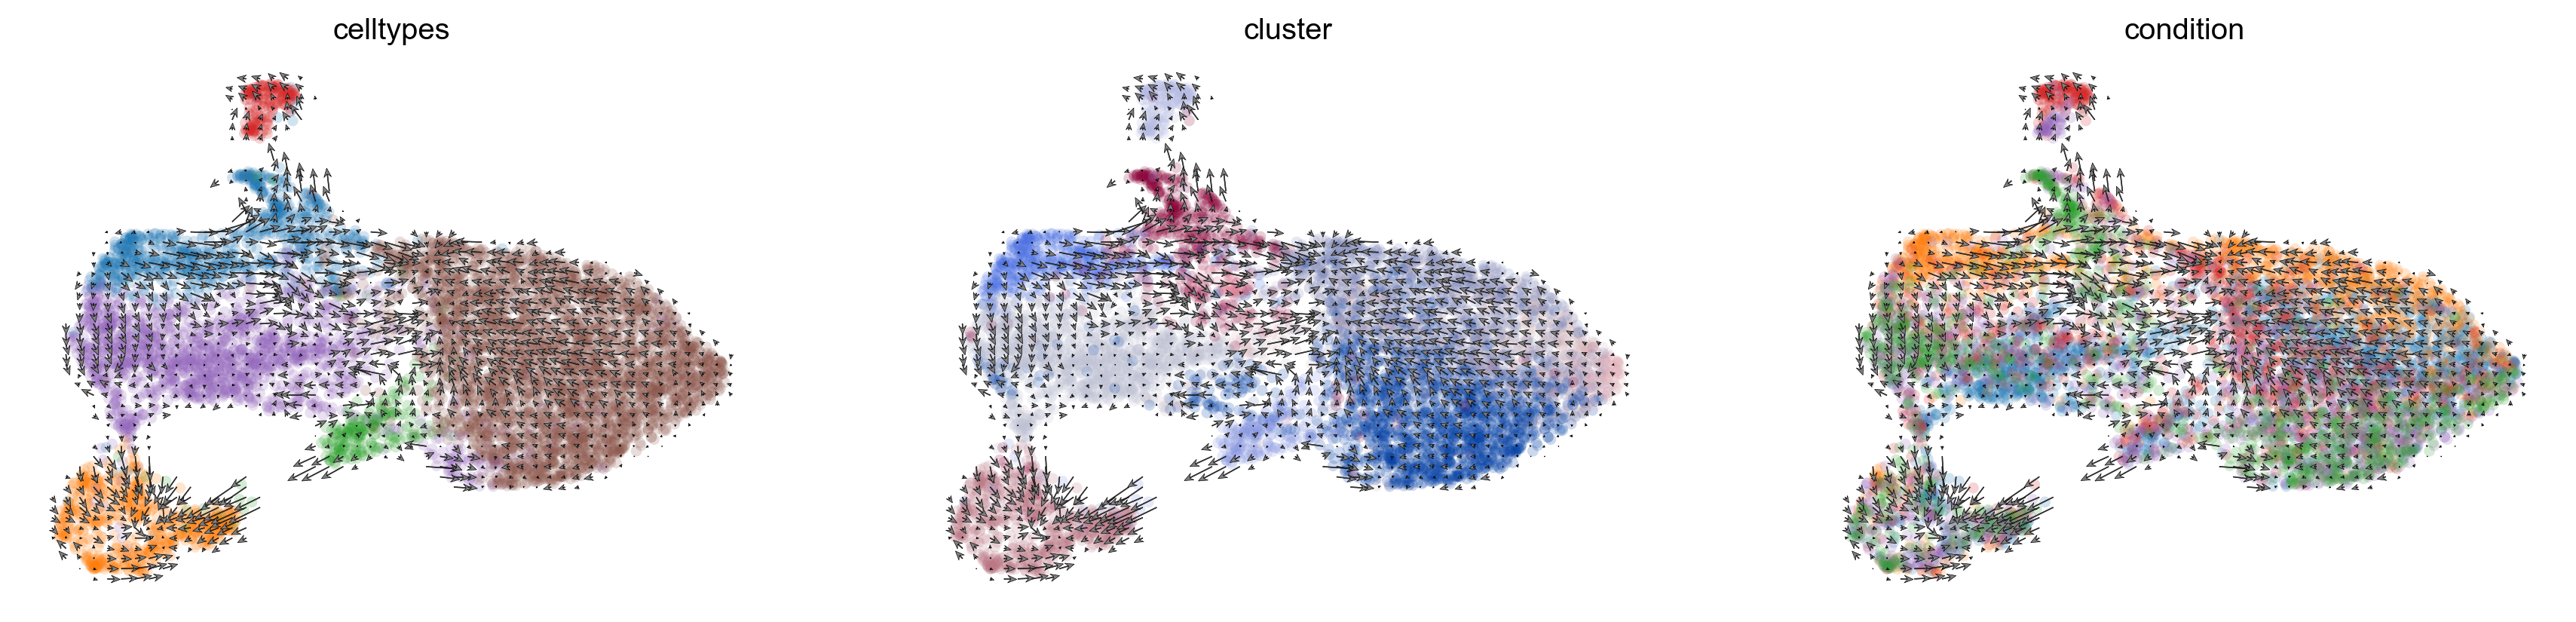

In [26]:
scv.pl.velocity_embedding_grid(adata, color = ['celltypes',  'cluster', 'condition'], 
                               dpi=120, arrow_size=2, arrow_length=4,
                               smooth=0.5, min_mass=1,
                               save=os.path.join(outDir, 
                                                 "RNAvelocity_gridEmbedding_model_dynamical" + parameters + ".pdf")
                              )


In [27]:
######################################################################## 
######################################################################## 
#### TEST PAGA ########
######################################################################## 
######################################################################## 



/Users/jingkui.wang/anaconda3/envs/cellrank/lib/python3.7/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


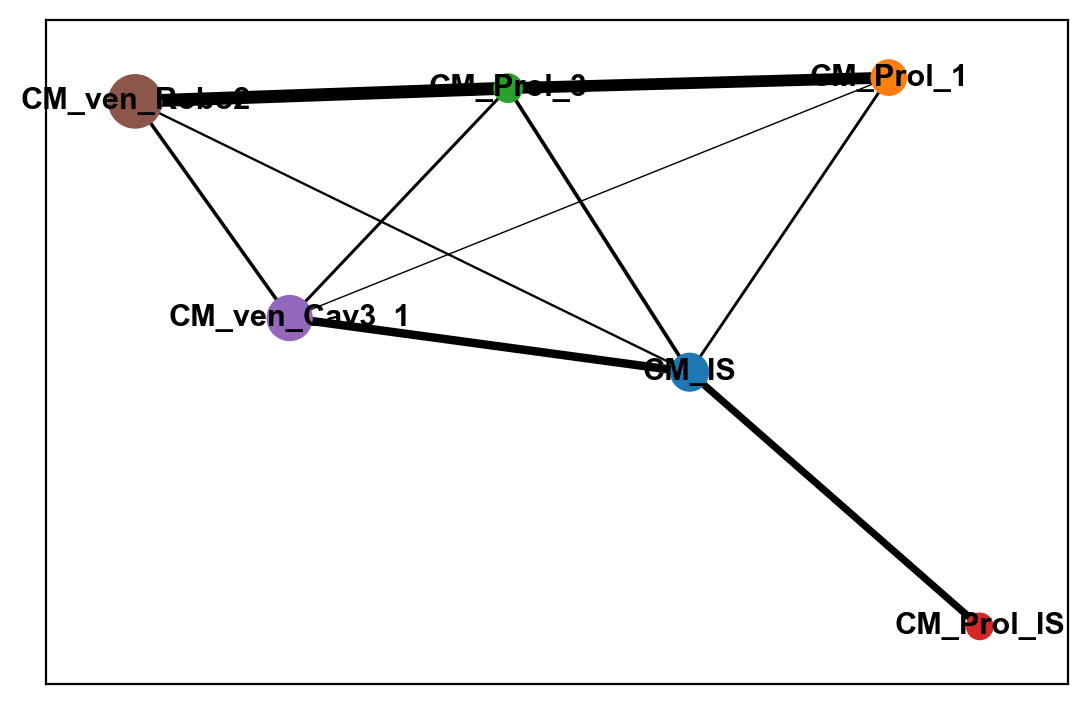

In [28]:
sc.tl.paga(adata, groups='celltypes')
sc.pl.paga(adata, 
           color=['celltypes'], threshold=0.05, show=True,
        )


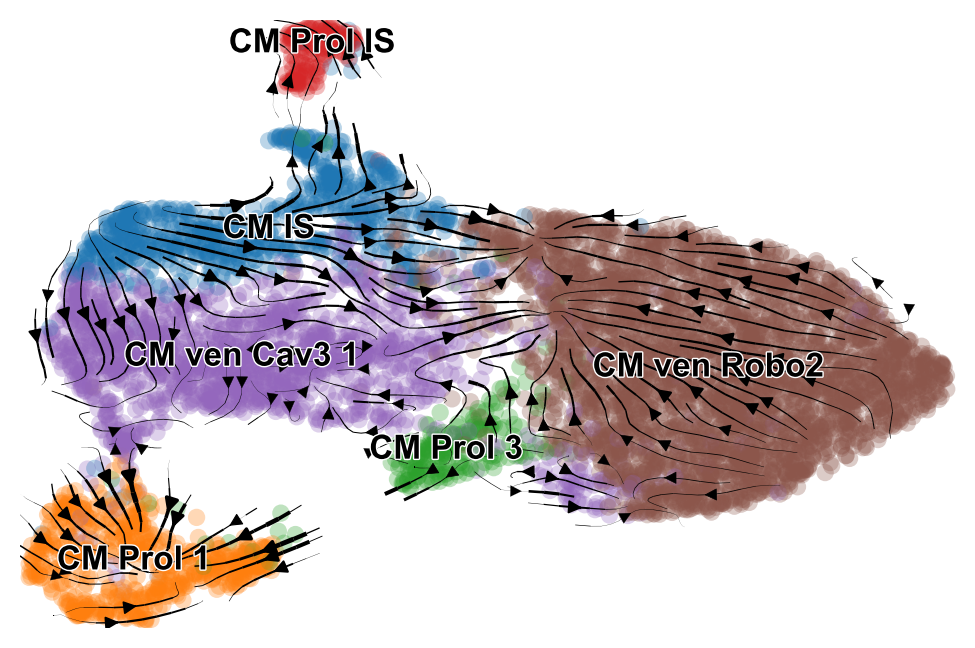

In [29]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", smooth=0.5, min_mass=1,
    legend_fontsize=12, title="", color = "celltypes"
)

/Users/jingkui.wang/anaconda3/envs/cellrank/lib/python3.7/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


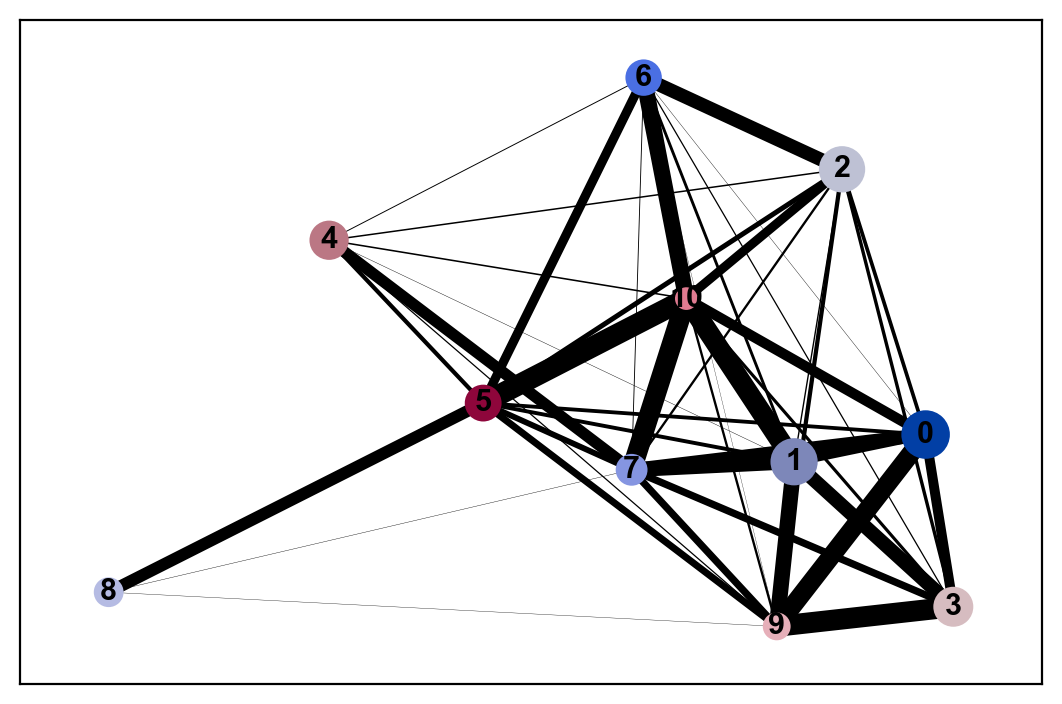

In [31]:
sc.tl.paga(adata, groups='cluster')
sc.pl.paga(adata, color=['cluster'])


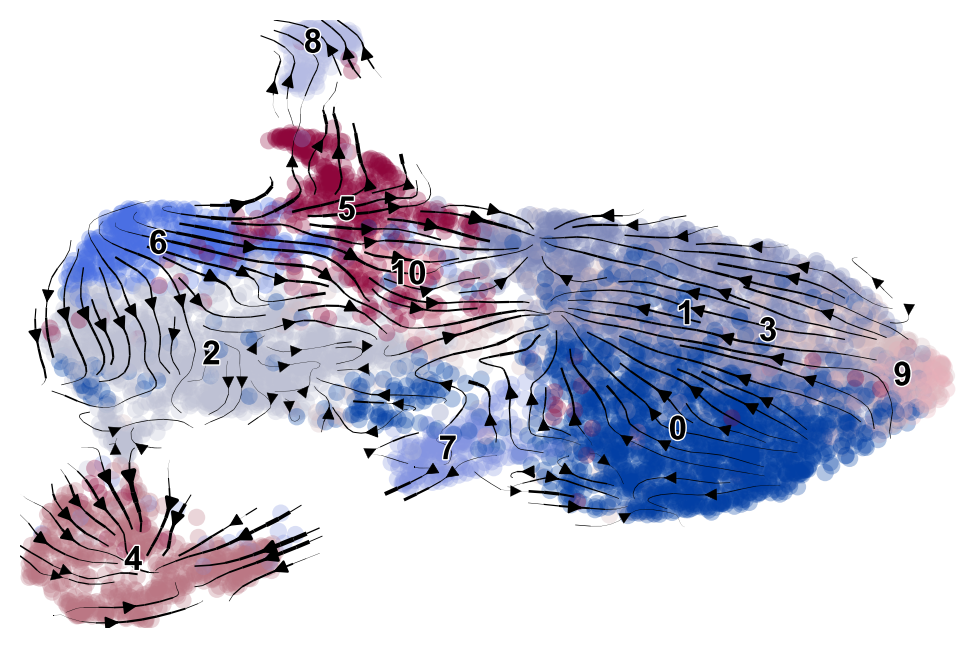

In [32]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", smooth=0.5, min_mass=1,
    legend_fontsize=12, title="", color = "cluster"
)

computing terminal states
    identified 9 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/Users/jingkui.wang/anaconda3/envs/cellrank/lib/python3.7/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


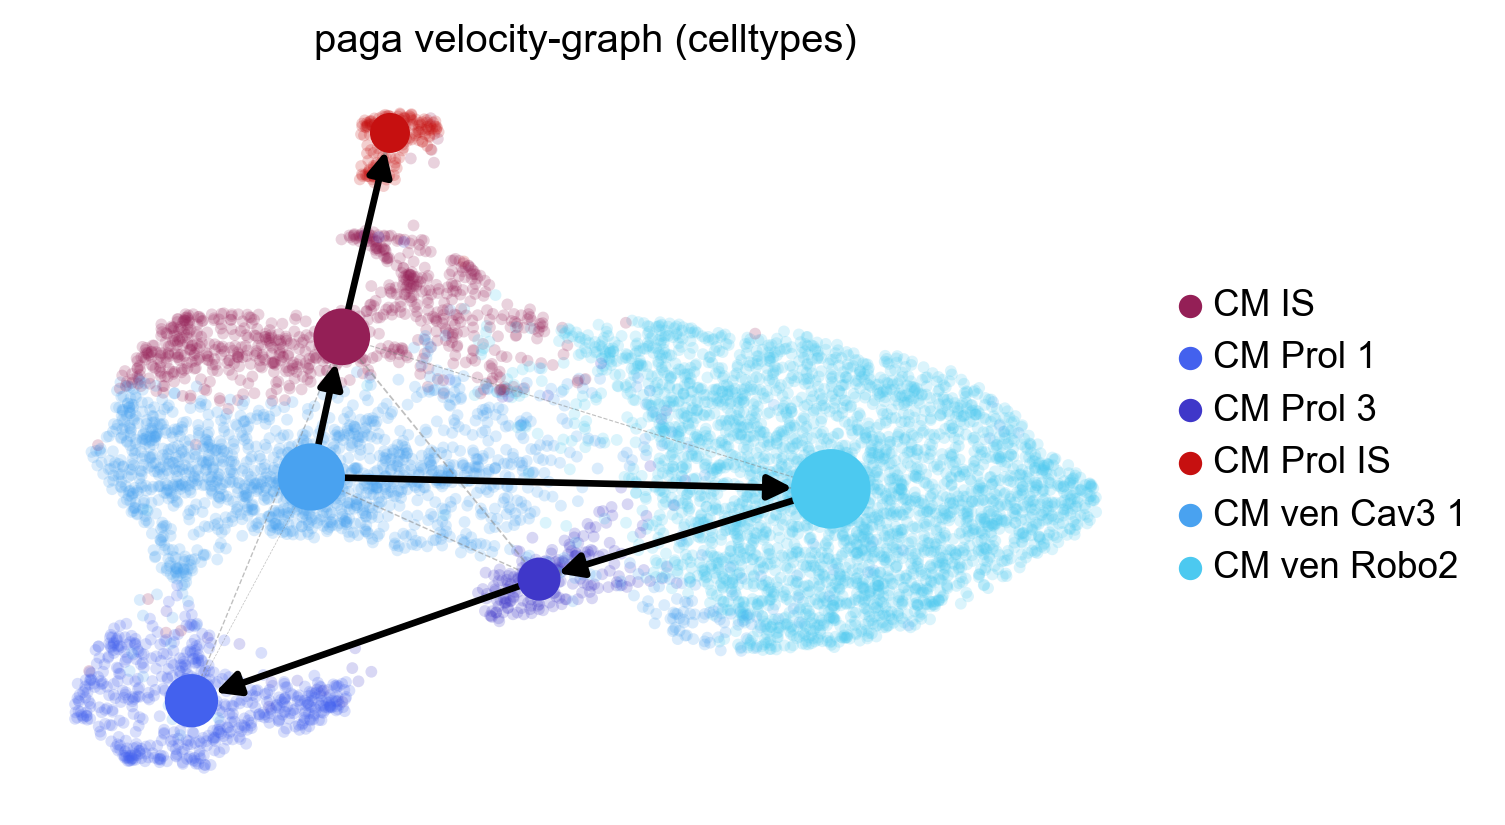

In [33]:
scv.tl.paga(adata, groups='celltypes')

/Users/jingkui.wang/anaconda3/envs/cellrank/lib/python3.7/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


saving figure to file ../results/sc_multiome_R13591_intron.exon.20220729/CM_trajectory_test/CMsutypesAll_2.1/scvelo_PAGA_umap_model.dynamicalthreshold.0.01_edges.adjusted.pdf


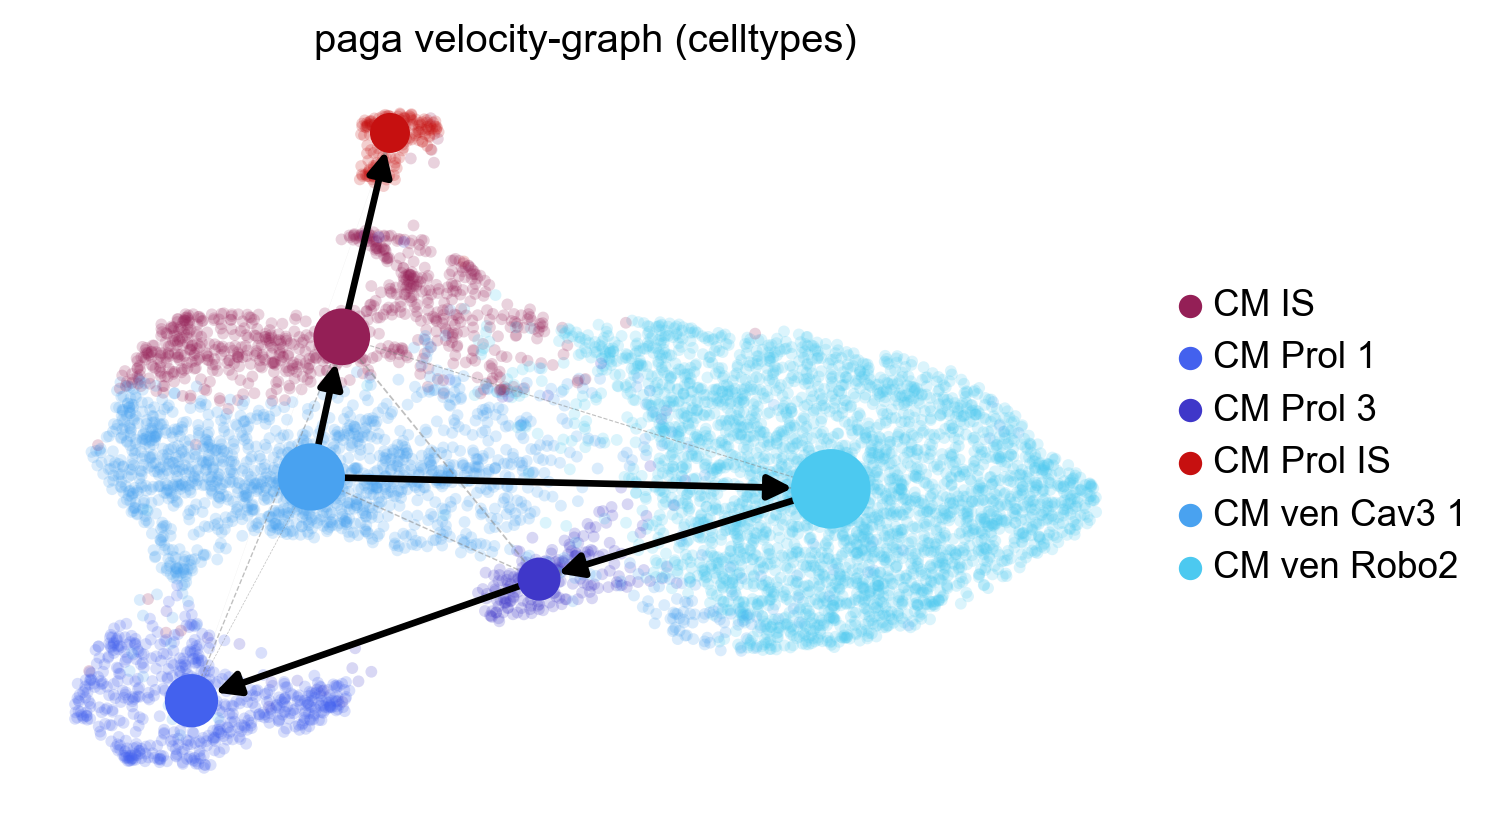

In [40]:
threshold = 0.01
scv.pl.paga(adata, basis='umap', size=50, alpha=0.2,
            threshold = threshold,
            min_edge_width=2, node_size_scale=1.5, 
            dpi = 120, 
            show=True,
            palette={"CM_ven_Robo2": "#4CC9F0",  
                     "CM_ven_Cav3_1": "#49A2F0",
                     "CM_IS": "#941F56",
                     "CM_Prol_IS": "#C61010",
                     "CM_Prol_1": "#4361EE",
                     "CM_Prol_3": "#3F37C9"
                    },
            save="PAGA_umap_model." + 'dynamical' + "_threshold." +str(threshold) + "_edges.adjusted.pdf"
            
           )